# Read in the data

In [42]:
%matplotlib inline
import pandas as pd
import numpy as np
import re as re
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    #set key and value in data dictionary - data[key]=dataframe
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [43]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
#set key and value in data dictionary
data["survey"] = survey

# Add DBN columns

In [44]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [45]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [46]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [47]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [48]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [49]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [50]:
correlations = combined.corr()
correlations = correlations["sat_score"]
#type(correlations)
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [51]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

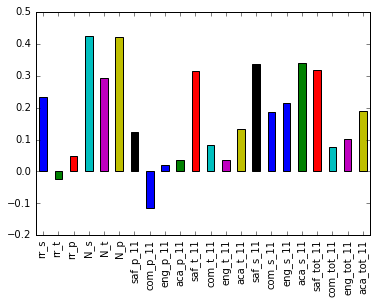

In [52]:
correlations[survey_fields].plot.bar()
plt.show()

In [53]:
#Top correlations are:
#Num of student respondents, num of parent respondents, student academic
#expectations, safety and respect

#Bottom correlations are:
#Parent responses on communication, engagement, academic expectation

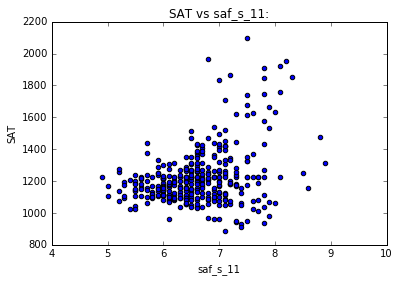

In [113]:
fig, ax=plt.subplots()
ax.scatter(combined["saf_s_11"], combined["sat_score"])
ax.set_xlabel("saf_s_11")
ax.set_ylabel("SAT")
ax.set_title("SAT vs saf_s_11:")
plt.show()

In [55]:
#There is a moderate correlation of 0.338 between student safety/respect
#and SAT scores.  The relationship weakens above 7 - more scatter.

In [56]:
#correlation between certain columns in df
combined[["saf_s_11","sat_score"]].corr()

,saf_s_11,sat_score
saf_s_11,1.000000,0.337639
sat_score,0.337639,1.000000


In [57]:
#create df that groups by district.  need to map avg for safety,
#longitude and latititude
safety_by_dist=(
    combined[["school_dist","saf_s_11","lon","lat"]]
    .groupby("school_dist")
    .agg(np.mean)
                )

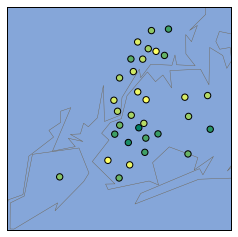

In [58]:
m=Basemap(
    projection='merc',
    llcrnrlat=40.496044,
    urcrnrlat=40.915256,
    llcrnrlon=-74.255735,
    urcrnrlon=-73.700272,
    resolution='i'
    )
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47',linewidth=.4)
m.drawrivers(color='#6D5F47',linewidth=.4)

longitudes=safety_by_dist["lon"].tolist()
latitudes=safety_by_dist["lat"].tolist()

#use c and cmap to plot safety and map to colors
m.scatter(longitudes,latitudes,s=40,zorder=2,latlon=True,c=safety_by_dist["saf_s_11"],cmap="summer")
plt.show()

In [59]:
#Brooklyn is less safe than other neighborhoods, it is darkest green

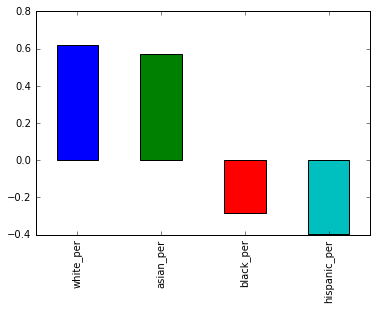

In [60]:
correlations[["white_per","asian_per","black_per","hispanic_per"]].plot.bar()
plt.show()

In [61]:
#white/asian race percentage is positively correlated to SAT
#black/hispanic race percentage is positively correlated to SAT

In [62]:
combined[["SCHOOL NAME","sat_score"]].describe()

,sat_score
count,363.000000
mean,1223.438806
std,178.223775
min,887.000000
25%,1113.000000
50%,1193.000000
75%,1266.500000
max,2096.000000


In [63]:
combined[["SCHOOL NAME","hispanic_per"]].describe()

,hispanic_per
count,363.000000
mean,44.068320
std,24.936881
min,2.400000
25%,21.000000
50%,45.900000
75%,63.800000
max,100.000000


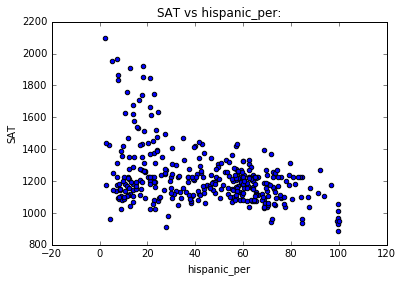

In [114]:
fig, ax = plt.subplots()
ax.scatter(combined["hispanic_per"], combined["sat_score"])
ax.set_xlabel("hispanic_per")
ax.set_ylabel("SAT")
ax.set_title("SAT vs hispanic_per:")
plt.show()

In [65]:
#SAT scores plumment when the hispanic percentage hits 100%

In [66]:
top_hispanic=combined[combined["hispanic_per"]>95]
top_hispanic=top_hispanic[["SCHOOL NAME","hispanic_per"]]
print(top_hispanic)

                                           SCHOOL NAME  hispanic_per
44                       MANHATTAN BRIDGES HIGH SCHOOL          99.8
82    WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL          96.7
89   GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...          99.8
125                ACADEMY FOR LANGUAGE AND TECHNOLOGY          99.4
141              INTERNATIONAL SCHOOL FOR LIBERAL ARTS          99.8
176   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE          99.8
253                          MULTICULTURAL HIGH SCHOOL          99.8
286             PAN AMERICAN INTERNATIONAL HIGH SCHOOL         100.0


In [67]:
#The top hispanic schools are for newly-arrived immigrants

In [68]:
bottom_hispanic=combined[(combined["hispanic_per"]<10) & (combined["sat_score"]>1800)]
bottom_hispanic=bottom_hispanic[["SCHOOL NAME","hispanic_per"]]
print(bottom_hispanic)

                                           SCHOOL NAME  hispanic_per
37                              STUYVESANT HIGH SCHOOL           2.4
151                       BRONX HIGH SCHOOL OF SCIENCE           7.2
187                     BROOKLYN TECHNICAL HIGH SCHOOL           7.9
327  QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...           7.9
356                STATEN ISLAND TECHNICAL HIGH SCHOOL           5.3


In [69]:
#The bottom % hispanic schools are for gifted students

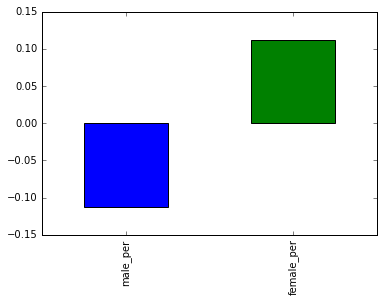

In [70]:
correlations[["male_per","female_per"]].plot.bar()

In [71]:
#Gender correlation to SAT - males negative, girls positive

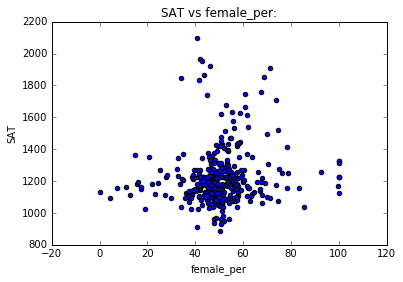

In [115]:
#REMEMBER () AFTER SUBPLOTS
fig, ax = plt.subplots()
ax.scatter(combined["female_per"], combined["sat_score"])
ax.set_xlabel("female_per")
ax.set_ylabel("SAT")
ax.set_title("SAT vs female_per:")
plt.show()

In [84]:
#relationship between female % and sat score is weak.  Best female 
# performance seems to happen when gender ratio is not lopsided.

In [103]:
top_female_per=combined[(combined["female_per"]>60) & (combined["sat_score"]>1700)]
print('Female_per over 60% - top SATs:')
top_female_per[["SCHOOL NAME","female_per","sat_score"]].sort_values(by=["sat_score"],ascending=False)

Female_per over 60% - top SATs:


,SCHOOL NAME,female_per,sat_score
302,TOWNSEND HARRIS HIGH SCHOOL,71.1,1910.0
5,BARD HIGH SCHOOL EARLY COLLEGE,68.7,1856.0
26,ELEANOR ROOSEVELT HIGH SCHOOL,67.5,1758.0
60,BEACON HIGH SCHOOL,61.0,1744.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,73.6,1707.0


In [104]:
#Townsend-high gredes and aptitude, mostly asian
#Bard gets college credit in HS
#Eleanor has lot of immigrants, free lunch
#Beacon has portfolio-based assessment
#Theme seems to be selection for aptitude and reliability

In [106]:
combined["ap_per"]=combined["AP Test Takers "]/combined["total_enrollment"]

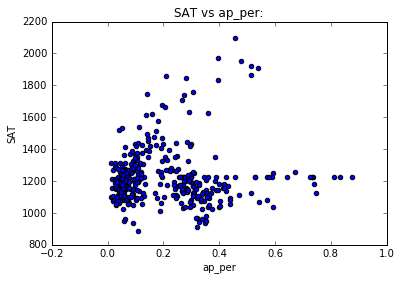

In [116]:
fig, ax = plt.subplots()
ax.scatter(combined["ap_per"],combined["sat_score"])
ax.set_xlabel("ap_per")
ax.set_ylabel("SAT")
ax.set_title("SAT vs ap_per:")
plt.show()

In [120]:
#Correlation of SAT to AP percentage is low.  Other factors are 
#driving the SAT.